In [237]:
import os
import sys
sys.path.append('../')
import numpy as np
import scipy.io as scio
import h5py
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms.functional import adjust_sharpness
import numba
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tempfile import gettempdir
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2DC
from kwave.utils import *
from kwave.ktransducer import *
from kwave.kmedium import kWaveMedium

%matplotlib inline

### Load in brain data

In [238]:
data_path = '/mnt/WD6TB/tianaoli/brains/'
data = scio.loadmat(os.path.join(data_path, '0.11.mat'))
brain3d = data['recondata_cut_mc_bgb']
print(brain3d.shape)
print(brain3d.min(), brain3d.max())

(256, 256, 256)
-1069.4133 3551.3313


### Visualization

In [239]:
x_sec = 100
y_sec = 100
z_sec = 100

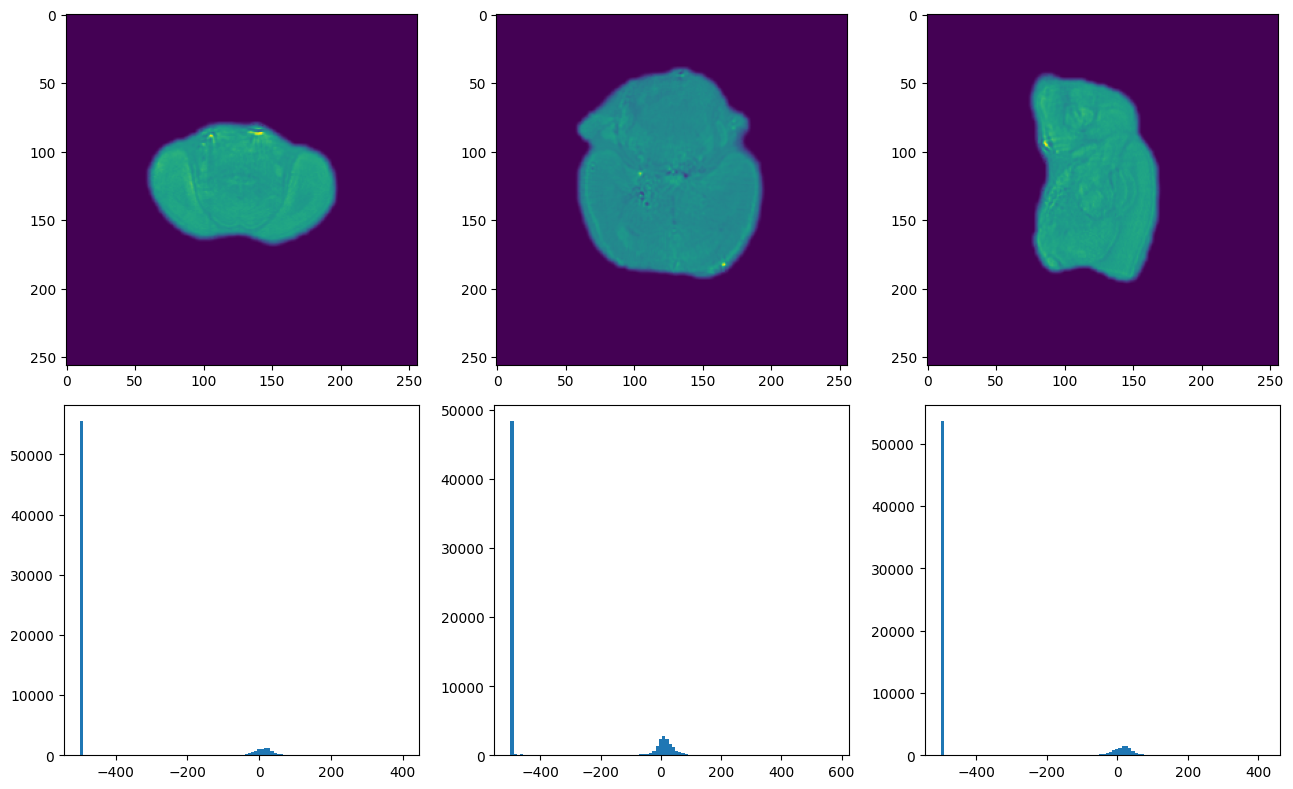

In [240]:
plt.figure(figsize=(13,8))
plt.subplot(2,3,1)
plt.imshow(brain3d[x_sec,:,:])

plt.subplot(2,3,4)
plt.hist(brain3d[x_sec,:,:].ravel(), bins=100)

plt.subplot(2,3,2)
plt.imshow(brain3d[:,y_sec,:])

plt.subplot(2,3,5)
plt.hist(brain3d[:,y_sec,:].ravel(), bins=100)

plt.subplot(2,3,3)
plt.imshow(brain3d[:,:,z_sec])

plt.subplot(2,3,6)
plt.hist(brain3d[:,:,z_sec].ravel(), bins=100)

plt.tight_layout()

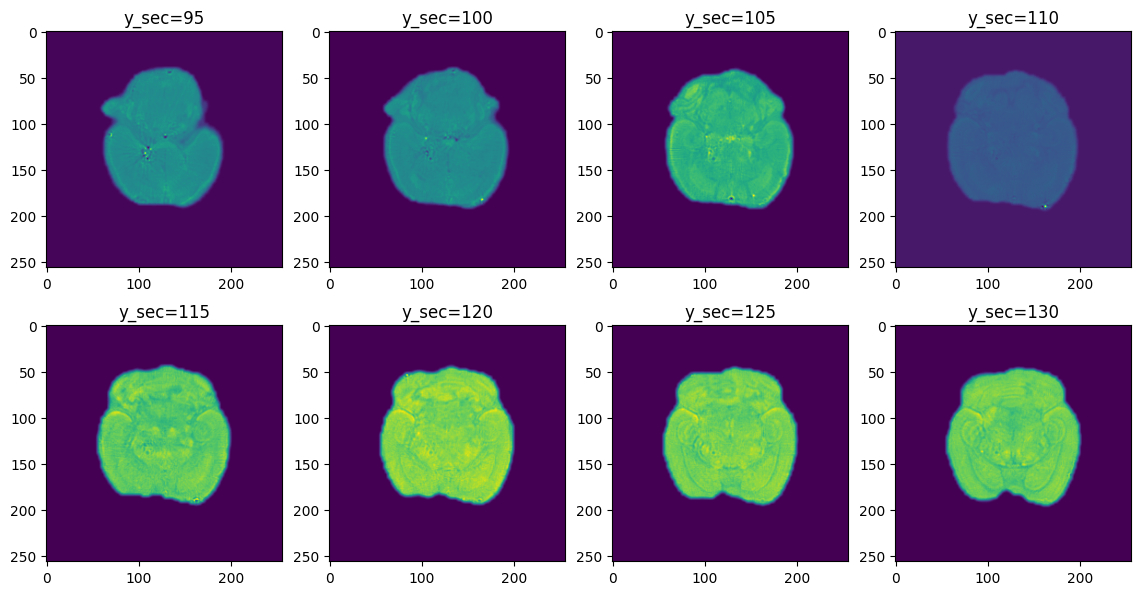

In [241]:
plt.figure(figsize=(14,7))
for i in range(8):
    plt.subplot(2,4,i+1)
    y_sec = i * 5 + 95
    plt.imshow(brain3d[:,y_sec,:])
    plt.title(f'y_sec={y_sec}')

Interpolate to image to a pixel scale of 0.05mm.

In [242]:
section = brain3d[:,100,:]
section = torch.tensor(section[30:-55, 42:-43]).unsqueeze(0).unsqueeze(0)
print(section.shape)
section = (section - section.min()) / (section.max() - section.min())
section = F.interpolate(section, scale_factor=1.5, mode='bilinear')
print(section.shape)

torch.Size([1, 1, 171, 171])
torch.Size([1, 1, 256, 256])


Sharpen the image using first and second order gradients.

In [243]:
laplacian = torch.tensor([[[[-1, -1, -1],
                             [-1, 9, -1],
                             [-1, -1, -1]]]], dtype=torch.float32)
sobelx = torch.tensor([[[[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]]]], dtype=torch.float32)
sobely = torch.tensor([[[[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]]]], dtype=torch.float32)

Laplacian = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Laplacian.weight = nn.Parameter(laplacian, requires_grad=False)
Sobelx = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Sobelx.weight = nn.Parameter(sobelx, requires_grad=False)
Sobely = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding='same', bias=False)
Sobely.weight = nn.Parameter(sobely, requires_grad=False)

alpha, beta = 1.5, 1
edge2 = Laplacian(section).abs().squeeze(0).squeeze(0)
edge1x = Sobelx(section).squeeze(0).squeeze(0)
edge1y = Sobely(section).squeeze(0).squeeze(0)
edge1 = torch.sqrt(edge1x**2 + edge1y**2)
section = section.squeeze(0).squeeze(0)
section_sharp = section + edge1 * alpha + edge2 * beta

Visualize the gradients and sharpened image.

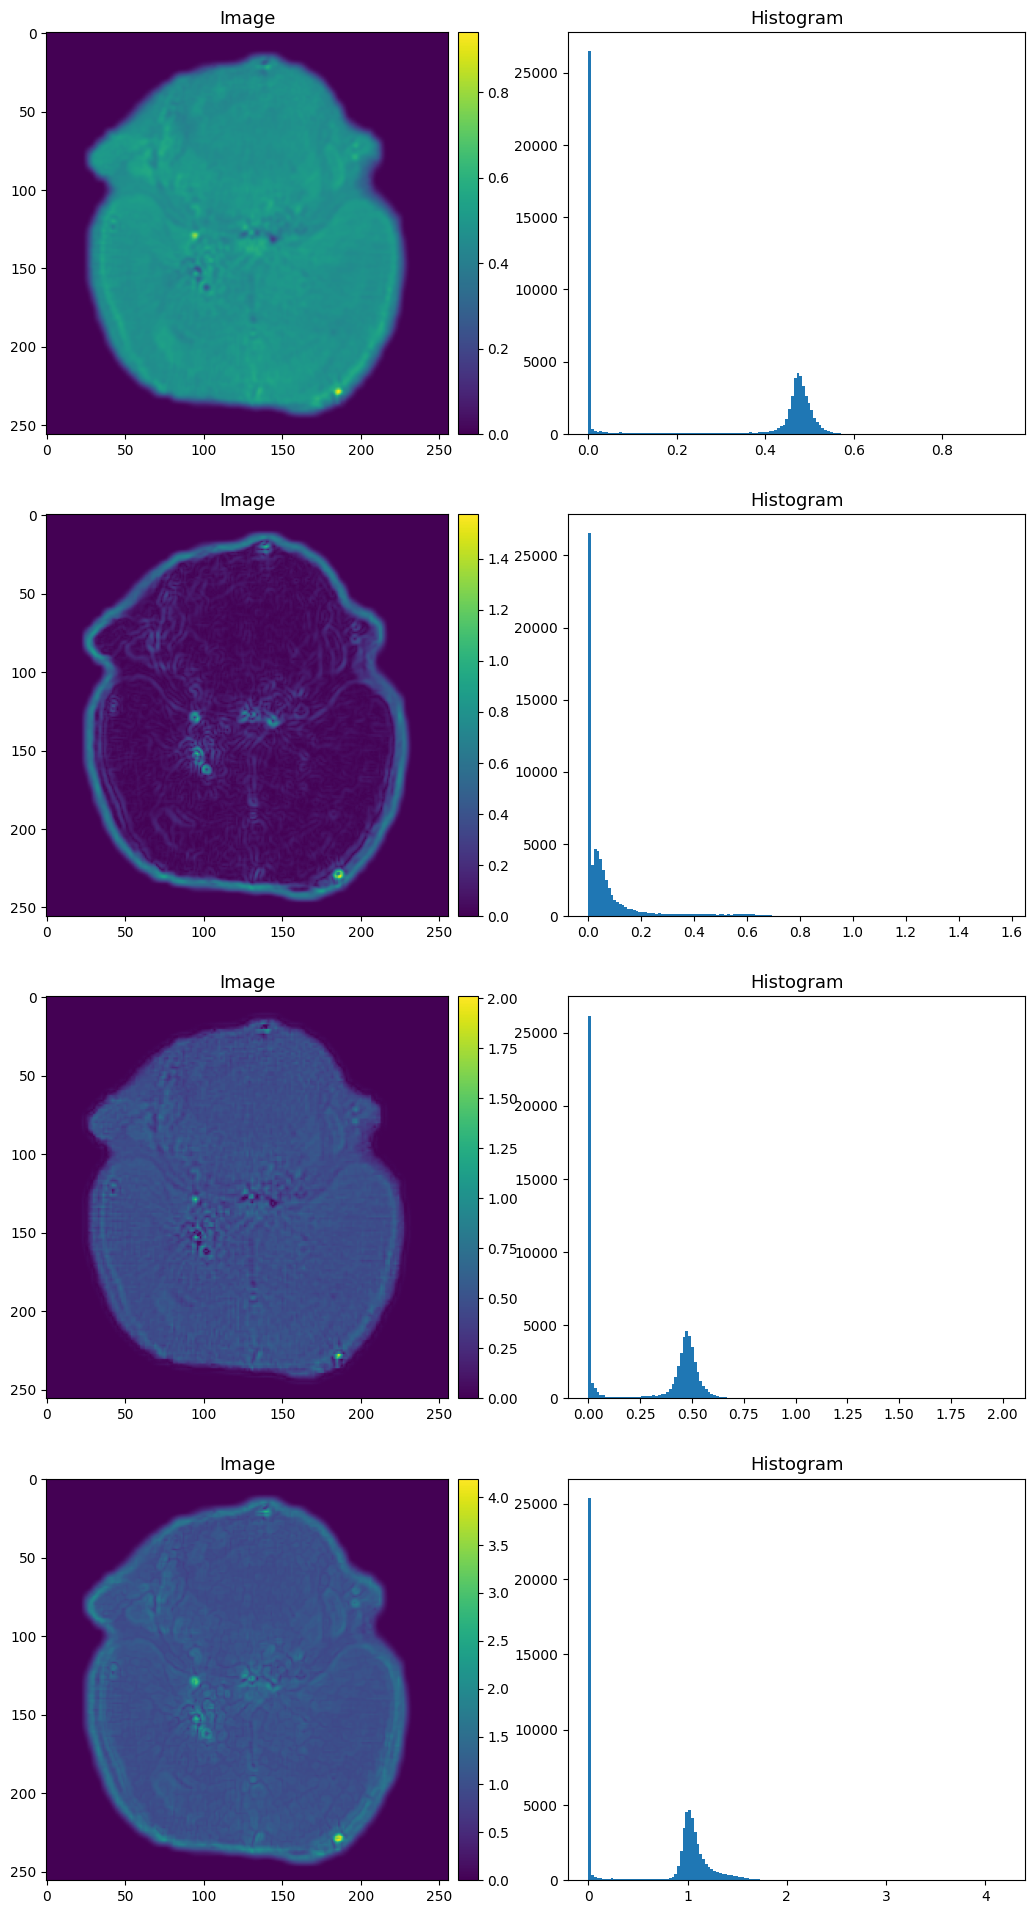

In [244]:
fig = plt.figure(figsize=(13,24))
for idx, img in enumerate([section, edge1, edge2, section_sharp]):
    ax = plt.subplot(4, 2, 2*idx+1)
    plt.imshow(img)
    plt.title('Image', fontsize=13)
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.015, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.ax.tick_params(labelsize=10)

    ax2 = plt.subplot(4, 2, 2*idx+2)
    plt.hist(img.ravel(), bins=150)
    plt.title('Histogram', fontsize=13)

Crop the sharpened image into small patches.

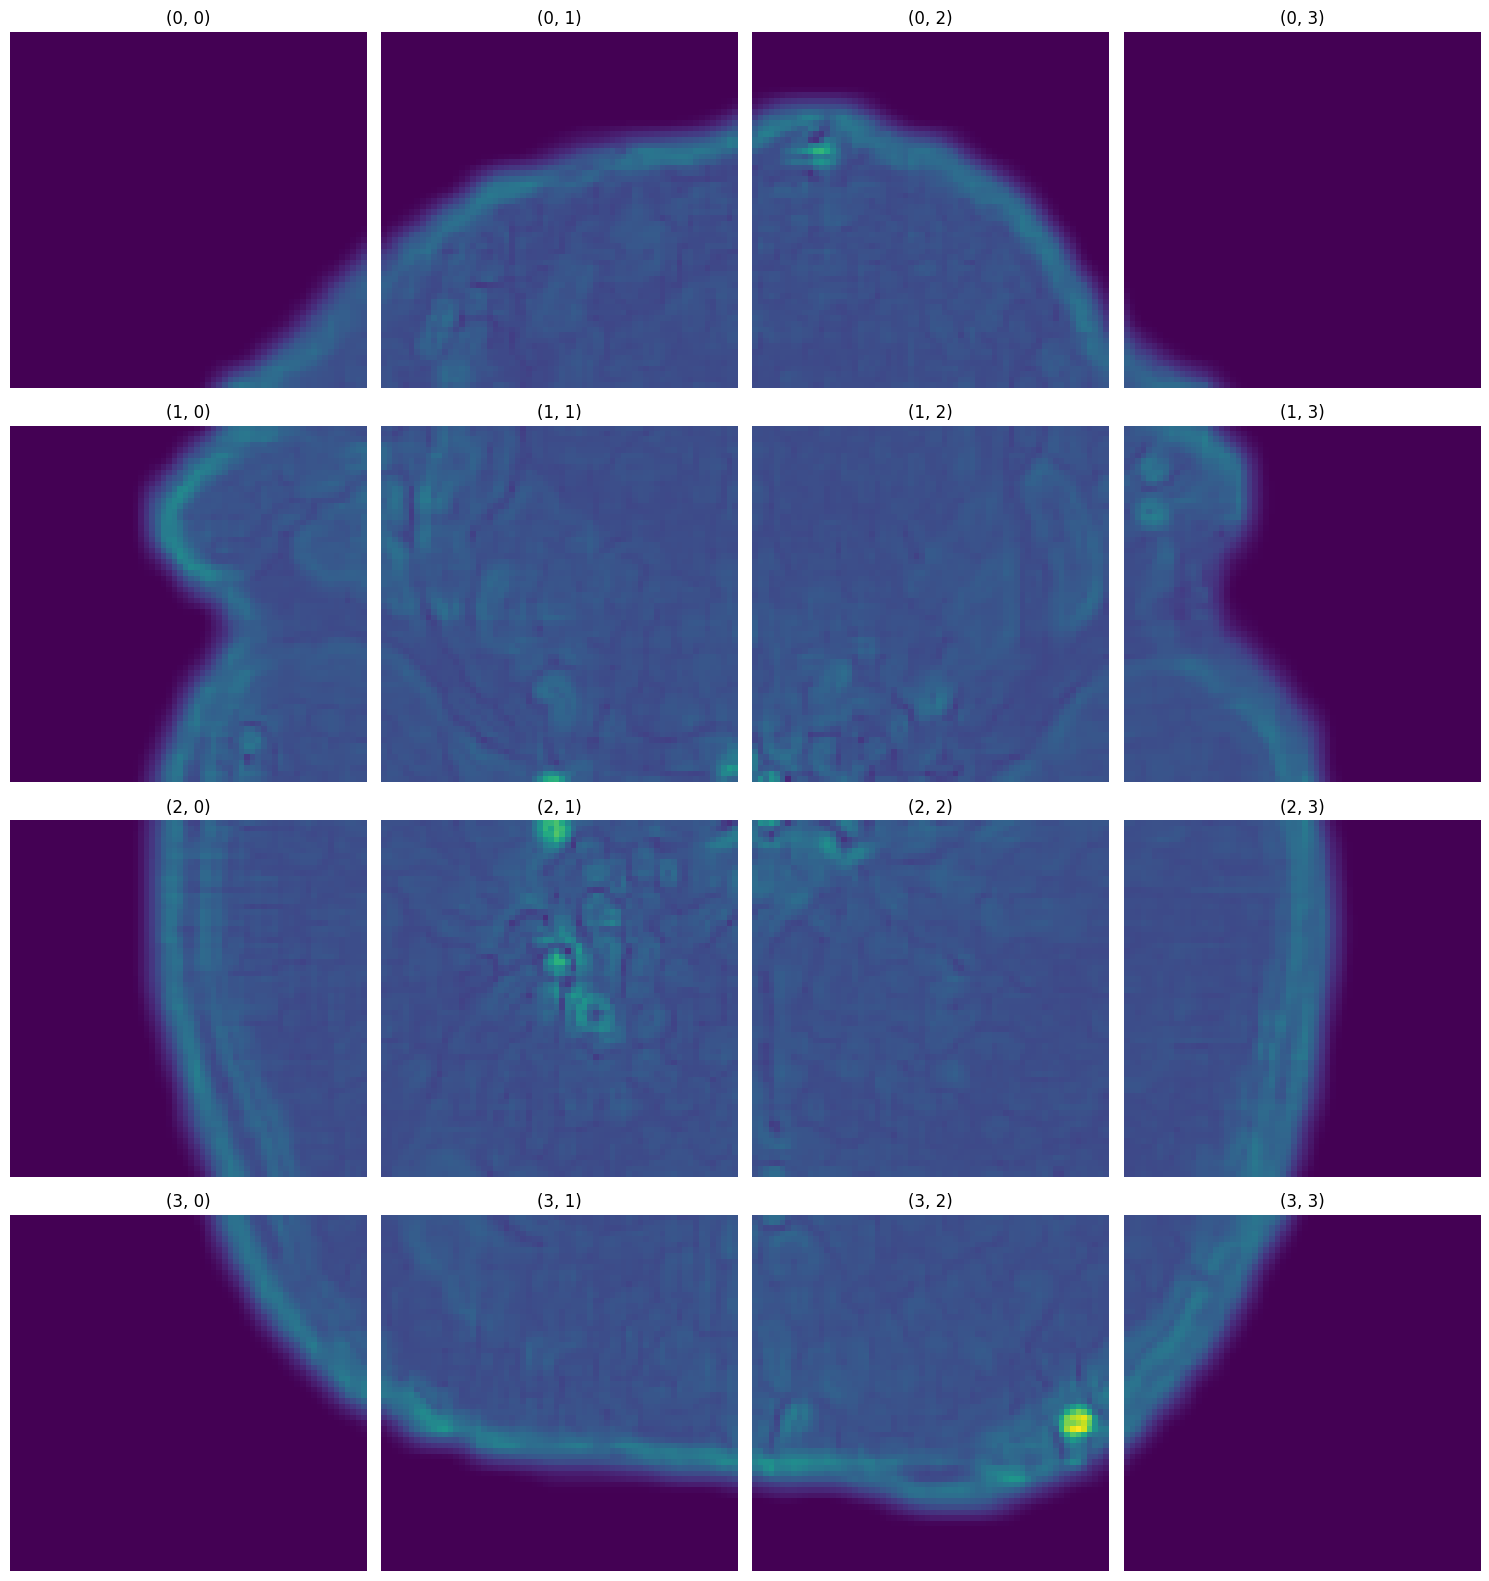

In [245]:
fig = plt.figure(figsize=(15,16))
norm = matplotlib.colors.Normalize(vmax=section_sharp.max(), vmin=section_sharp.min())
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.imshow(section_sharp[64*i:64*(i+1),64*j:64*(j+1)], norm=norm)
        plt.axis('off')
        plt.title(f'({i}, {j})')
plt.tight_layout()

Save this image as the initial pressure distribution to be used in k-wave simulations.

In [246]:
np.save('data/brain/IP_brain.npy', section_sharp.numpy())

In [247]:
# fig = plt.figure(figsize=(11,11))
# for idx, img in enumerate([section, section_sharp, edge1, edge2]):
#     plt.subplot(2,2,idx+1)
#     plt.imshow(img)
#     plt.axis('off')
#     title = ['Image', 'Sharpened Image', '1st Order Gradient', '2nd Order Gradient']
#     plt.title(title[idx], fontsize=18)
# plt.tight_layout()